In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png

from epics import ca
ca.finalize_libca()

%matplotlib inline

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [3]:
exp_type = 'fwhm_lwsi'

In [4]:
#base_dir = Path(aps.__file__).parents[1]
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing")
data_base_dir = autoalign_dir / exp_type / 'raw'
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


In [5]:
log_files = sorted(list(data_base_dir.glob('*.gz')))
hist_dirs = sorted(list(data_base_dir.glob('*steps')))
ini_files = sorted(list(data_base_dir.glob('*ini')))
image_dirs = sorted(list(data_base_dir.glob('*images')))
log_files, hist_dirs, ini_files

([PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/raw/fwhm_lwsi_moo_optimization_final_150_2022-11-19_14:37.gz'),
  PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/raw/fwhm_lwsi_optimization_final_150_2022-11-18_23:21.gz')],
 [PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/raw/fwhm_lwsi_150_2022-11-18_steps'),
  PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/raw/fwhm_lwsi_moo_150_2022-11-19_steps')],
 [PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/raw/fwhm_lwsi_autofocusing.ini'),
  PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/fwhm_lwsi/raw/fwhm_lwsi_moo_autofocusing.ini')])

### fwhm_lwsi

In [6]:
!ls $data_base_dir

fwhm_lwsi_150_2022-11-18_images
fwhm_lwsi_150_2022-11-18_steps
fwhm_lwsi_autofocusing.ini
fwhm_lwsi_moo_150_2022-11-19_images
fwhm_lwsi_moo_150_2022-11-19_steps
fwhm_lwsi_moo_autofocusing.ini
fwhm_lwsi_moo_optimization_final_150_2022-11-19_14:37.gz
fwhm_lwsi_optimization_final_150_2022-11-18_23:21.gz


In [7]:
study = analysis.create_study_from_trials( data_base_dir / "fwhm_lwsi_optimization_final_150_2022-11-18_23:21.gz")

[I 2023-05-11 23:39:58,363] A new study created in memory with name: no-name-8743c541-d130-43b7-b8bd-027c10e22922


Assuming minimization for all objectives.


In [8]:
n_steps = len(study.trials)

In [9]:
hists = analysis.load_histograms_from_files(n_steps, data_base_dir / "fwhm_lwsi_150_2022-11-18_steps", extension='gz')

Trial number 10
Trial values: fwhm 3.960e-02 lwsi 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39004169030828023, 'h_fwhm': 0.034465956461326996, 'h_centroid': -0.00218736875319403, 'h_peak': -0.035441408059286666, 'v_sigma': 0.4571791306797694, 'v_fwhm': 0.019507620164127548, 'v_centroid': 0.0042048864577383105, 'v_peak': 0.020483001172332867, 'integral_intensity': 285.3211315646417, 'peak_intensity': 31237.688, 'gaussian_fit': {}}}


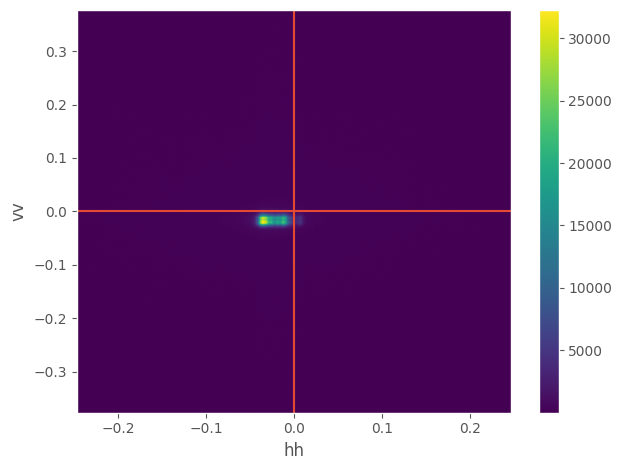

Trial number 85
Trial values: fwhm 1.059e-02 lwsi 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3904434978266455, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0011218357094990306, 'h_peak': -0.025686892079666578, 'v_sigma': 0.45778630290801625, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.003941001156517493, 'v_peak': 0.02698554122704176, 'integral_intensity': 284.70146785922464, 'peak_intensity': 65340.797, 'gaussian_fit': {}}}


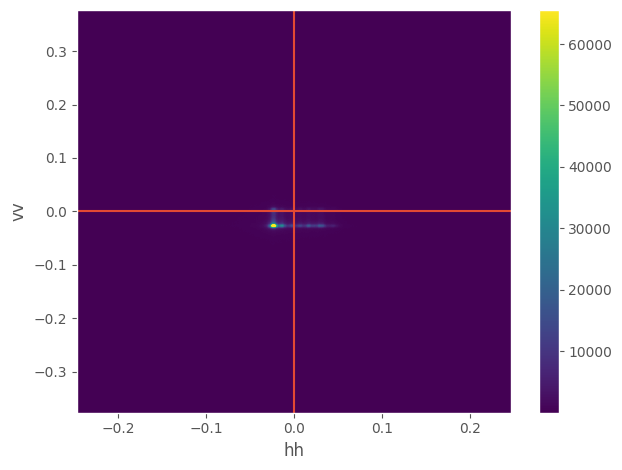

Trial number 145
Trial values: fwhm 5.322e-02 lwsi 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3904090781772309, 'h_fwhm': 0.04357017137563979, 'h_centroid': 0.0009941020395544675, 'h_peak': 0.0022760537285780058, 'v_sigma': 0.4576061998835951, 'v_fwhm': 0.03056193825713316, 'v_centroid': 0.005878752262676867, 'v_peak': 0.000975381008206341, 'integral_intensity': 284.76257632962825, 'peak_intensity': 24216.5, 'gaussian_fit': {}}}


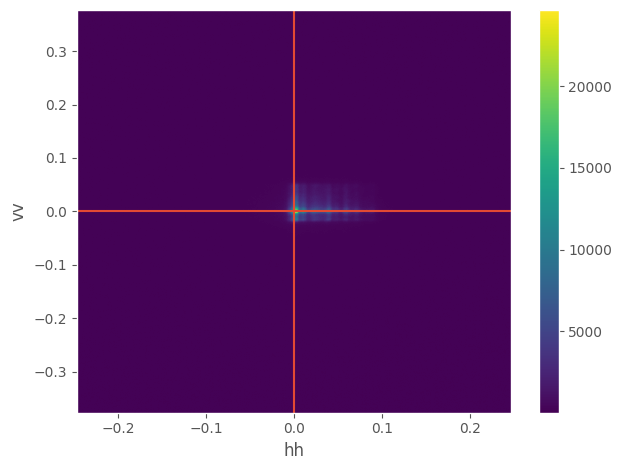

In [33]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: fwhm {t.values[0]:4.3e} lwsi {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.axvline(0)
    plt.axhline(0)
    plt.tight_layout()
    plt.colorbar()
    plt.show()

Result: Seems like the beam is too spread out in all the cases.

In [11]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [12]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)

[31, 148, 15]
85 [0.010585784588079523, 19.311638884165312]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3904434978266455, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0011218357094990306, 'h_peak': -0.025686892079666578, 'v_sigma': 0.45778630290801625, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.003941001156517493, 'v_peak': 0.02698554122704176, 'integral_intensity': 284.70146785922464, 'peak_intensity': 65340.797, 'gaussian_fit': {}}}


In [13]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["fwhm", "lwsi"], 
                                                  include_dominated_trials=True)
plt.scatter(*nash_trial.values, color='orange', label='Nash')
#plt.ylim(-11.14, -10.9)
#plt.xlim(0, 0.005)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/2426281823.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["fwhm", "lwsi"],


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/2135045621.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0],


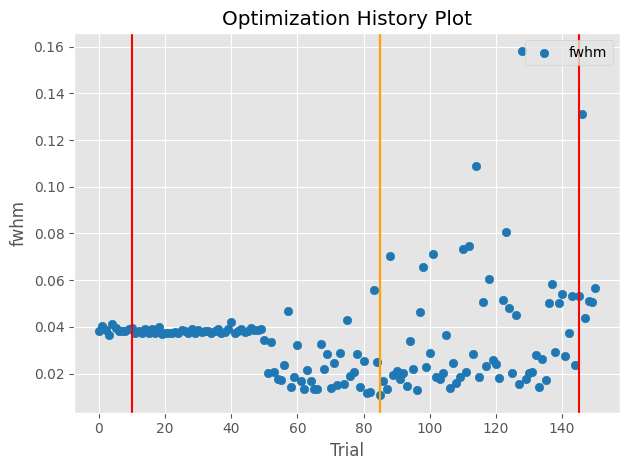

In [14]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], 
                                                          target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [15]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], 
                                                          target_name="lwsi")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/1513963145.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1],


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/2549631295.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: opt_common._get_peak_distance_from_dw(t.user_attrs['dw']),


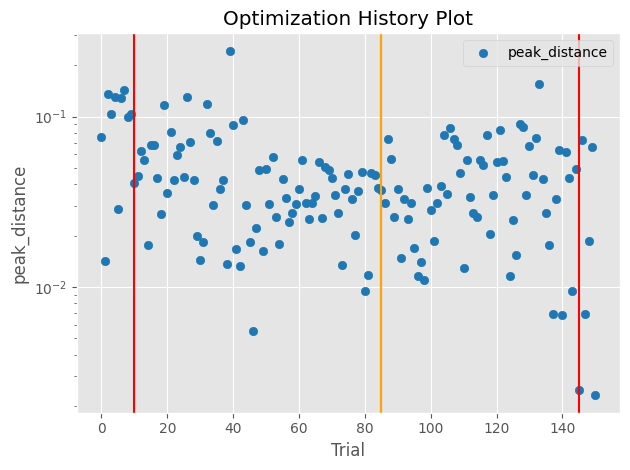

In [16]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: opt_common._get_peak_distance_from_dw(t.user_attrs['dw']), 
                                                          target_name="peak_distance")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.yscale('log')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [18]:
new_hists = []
new_dws = []
for h in hists:
    h1, dw = analysis.recalculate_info(h, noise_threshold=1.5, crop=500)
    new_hists.append(h1)
    new_dws.append(dw)

In [19]:
wsums = [opt_common._get_weighted_sum_intensity_from_hist(h1, 2) for h1 in new_hists]

In [20]:
wsums = np.array(wsums)

In [21]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums[t.number]),
                                                          target_name="log_weighted_sum")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/436633895.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums[t.number]),


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/4268674650.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: sigmas[t.number],


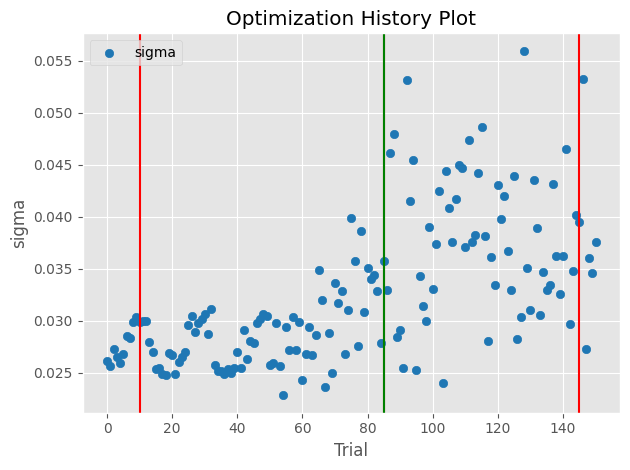

In [22]:
# Plotting the optimization histories
sigmas = [opt_common._get_sigma_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: sigmas[t.number],
                                                          target_name="sigma")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3370862287.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number],


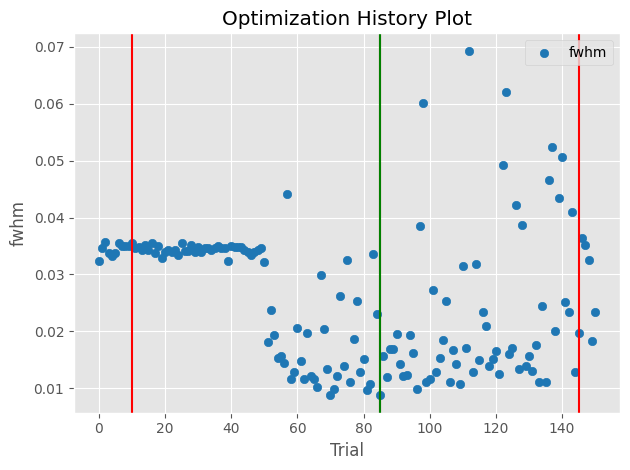

In [23]:
# Plotting the optimization histories
fwhms = [opt_common._get_fwhm_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number],
                                                          target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3952178995.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: kl_divs[t.number],


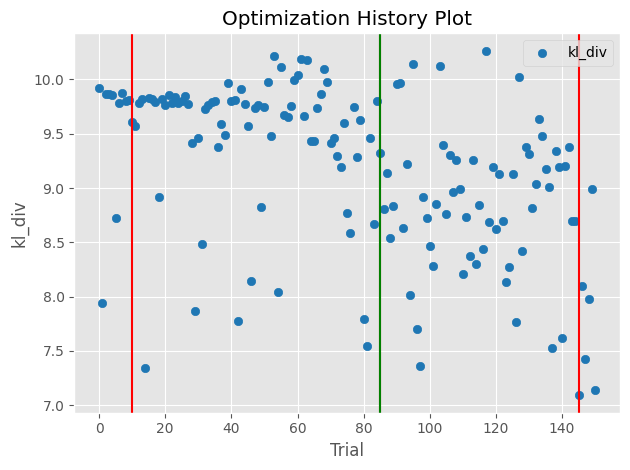

In [24]:
# Plotting the optimization histories
kl_divs  = [opt_common._get_kl_divergence_with_gaussian_from_hist(hist, ref_fwhm=(5e-3,5e-3)) for hist in new_hists]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: kl_divs[t.number],
                                                          target_name="kl_div")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/330897592.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: plocs[t.number],


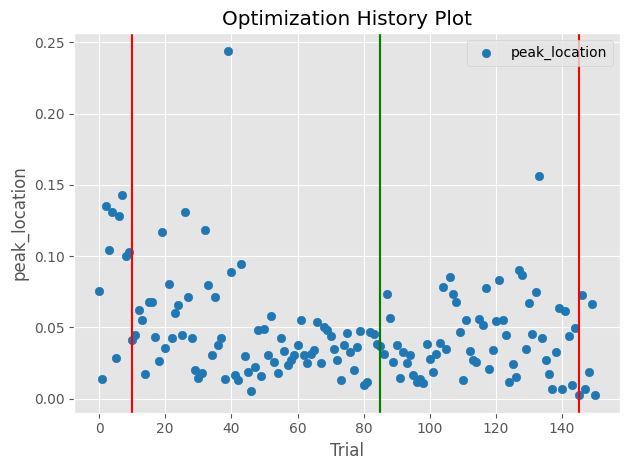

In [25]:
# Plotting the optimization histories
plocs = [opt_common._get_peak_distance_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: plocs[t.number],
                                                          target_name="peak_location")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [26]:
# Plotting the optimization histories
pints = [opt_common._get_peak_intensity_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: pints[t.number],
                                                          target_name="peak_intenisty")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3201353947.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: pints[t.number],


In [27]:
np.argmin(kl_divs)

145

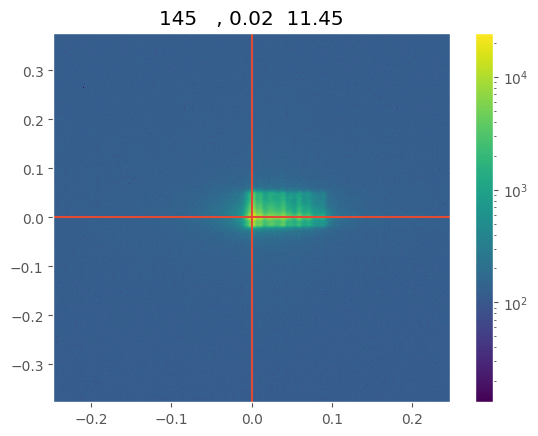

In [35]:
tnum = 145
hdata = hists[tnum]
fig, ax = plt.subplots(1,1)

cax = plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
plt.axvline(0)
plt.axhline(0)

val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[tnum]])
ax.set_title(f"{tnum:<6}, {val_strs}")
plt.colorbar(cax, ax=ax)
plt.show()

In [36]:
# FWHM, WSUM

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
                lambda t: np.log(wsums[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

96 6


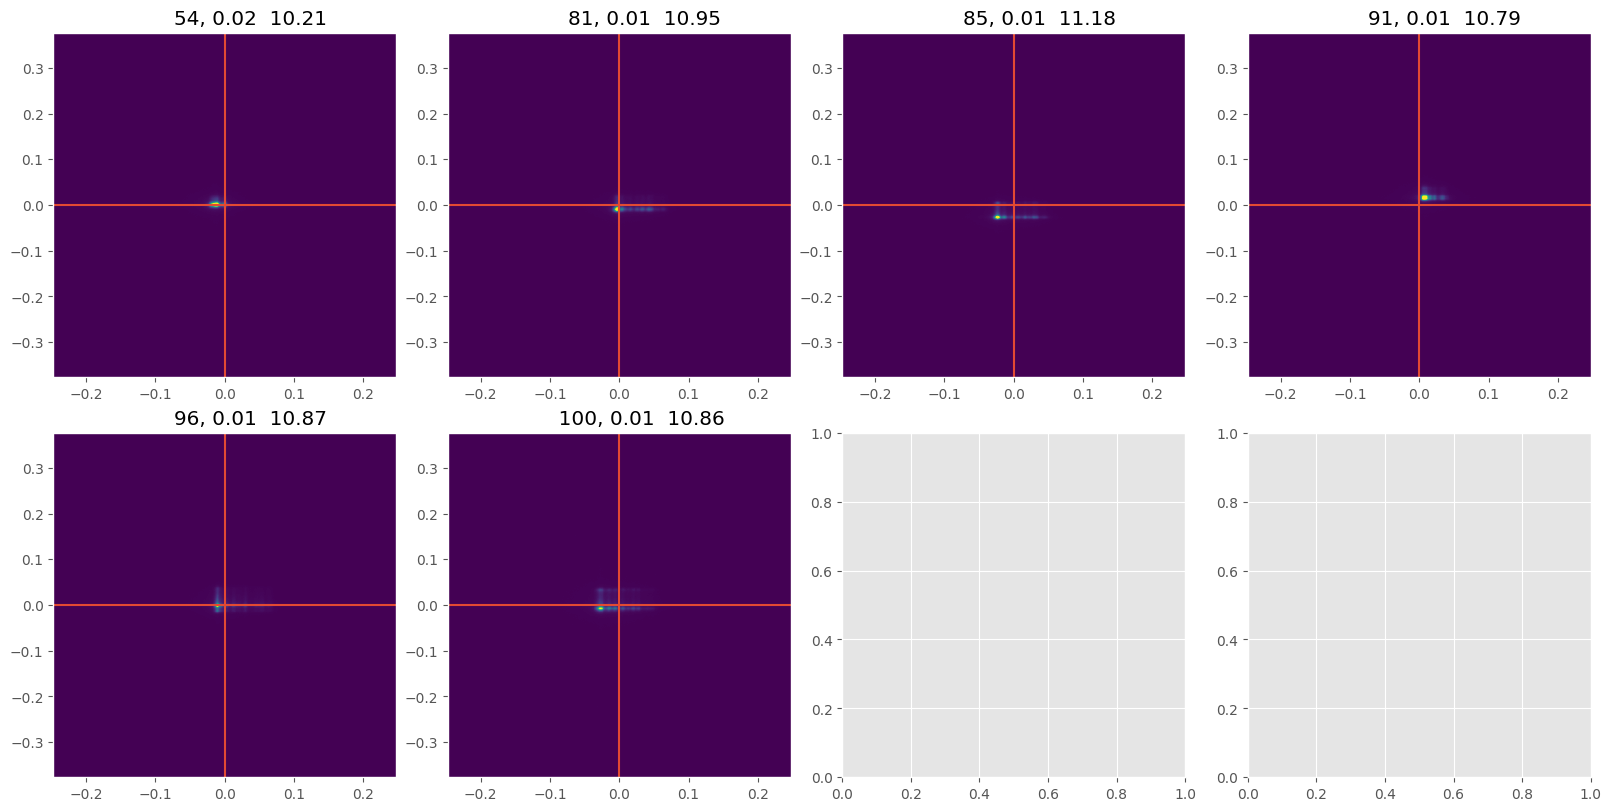

In [37]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4], constrained_layout=True)
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)#, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    #plt.colorbar(cax, ax=axs[i])
plt.show()

In [38]:
# FWHM, KL

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

81 3


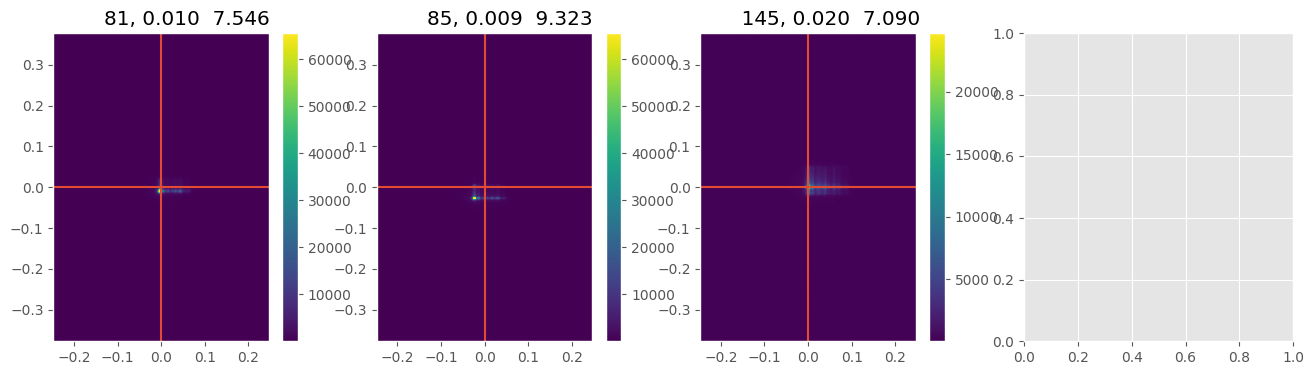

In [39]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)#, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [40]:
# centroid, KL

test_val_fns = [lambda t: opt_common._get_centroid_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

14 2


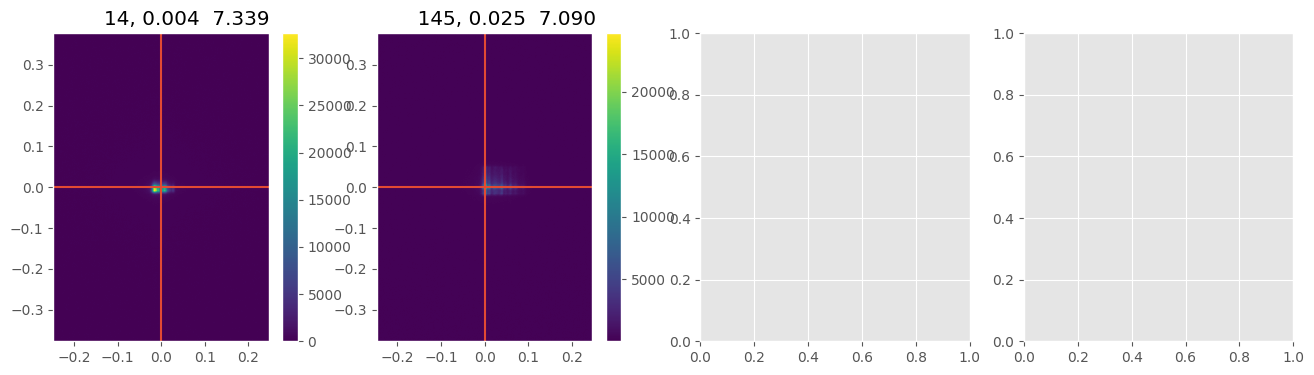

In [41]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T)#, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [42]:
# peak_location, KL

test_val_fns = [lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

145 2


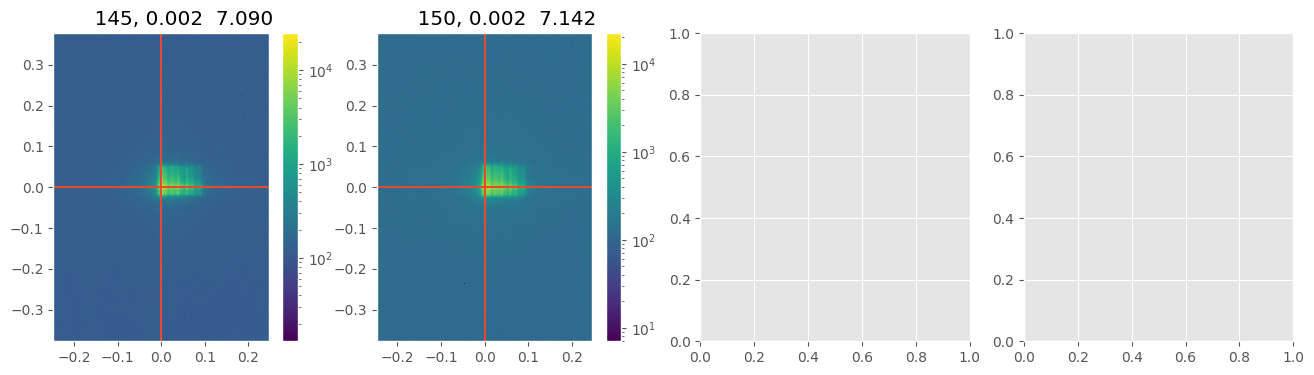

In [43]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [44]:
# peak_intensity, KL

test_val_fns = [lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])), 
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

81 7


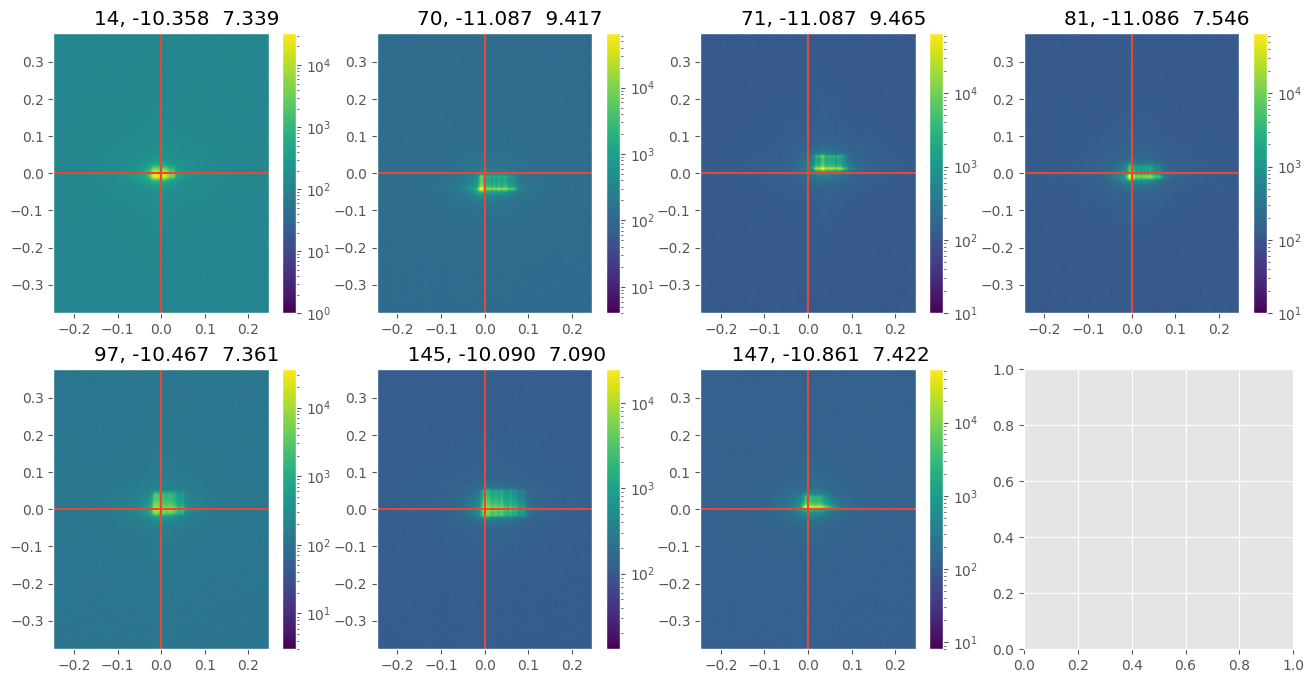

In [45]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [46]:
# peak_intensity, peak_location, KL

test_val_fns = [lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])), lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

81 12


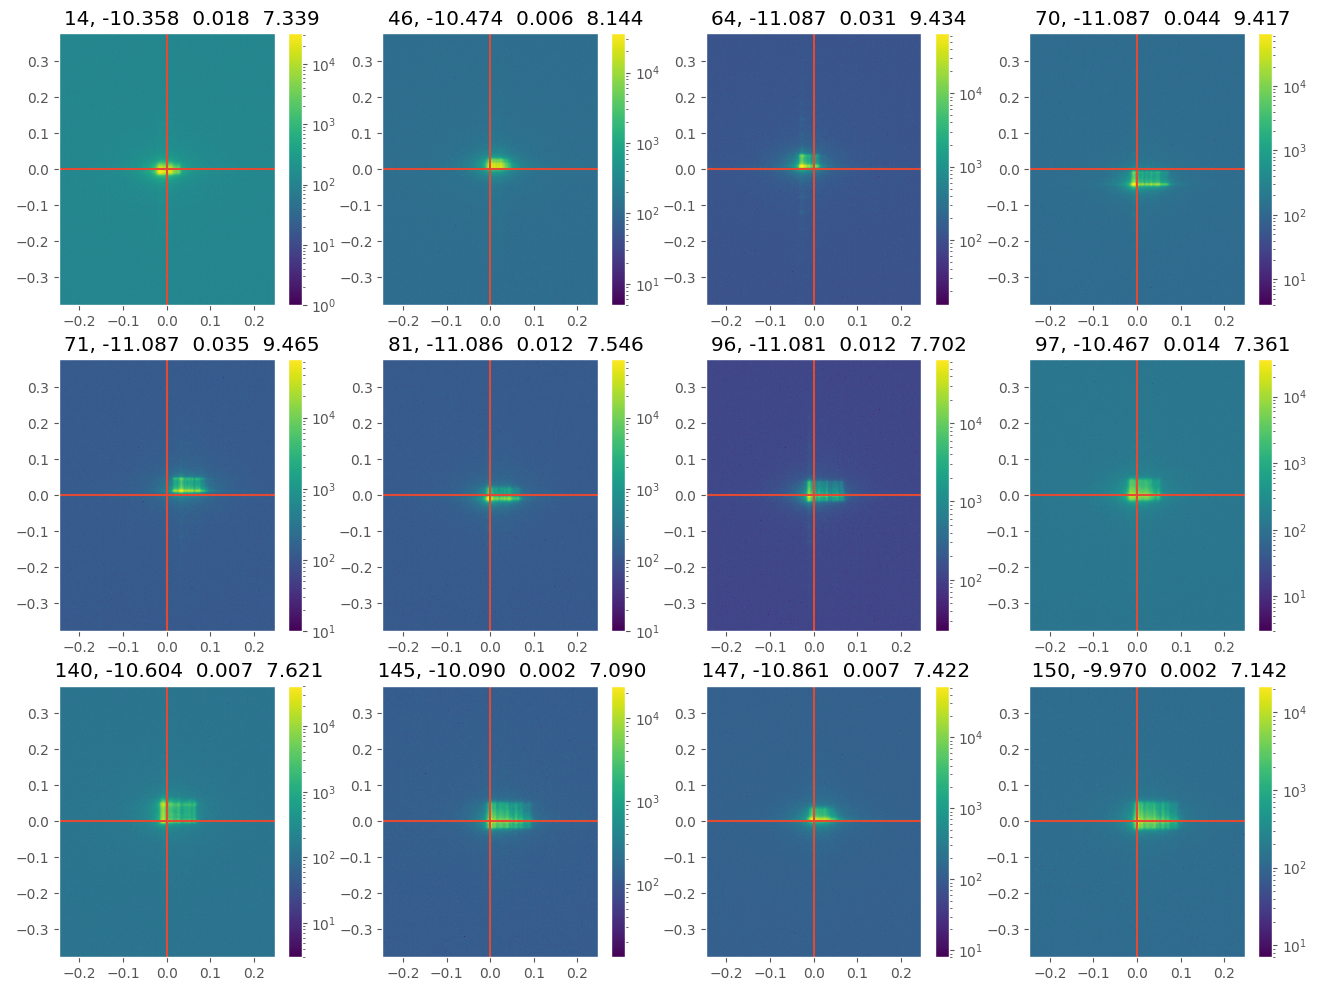

In [47]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

### fwhm_lwsi_moo_2022-11-19

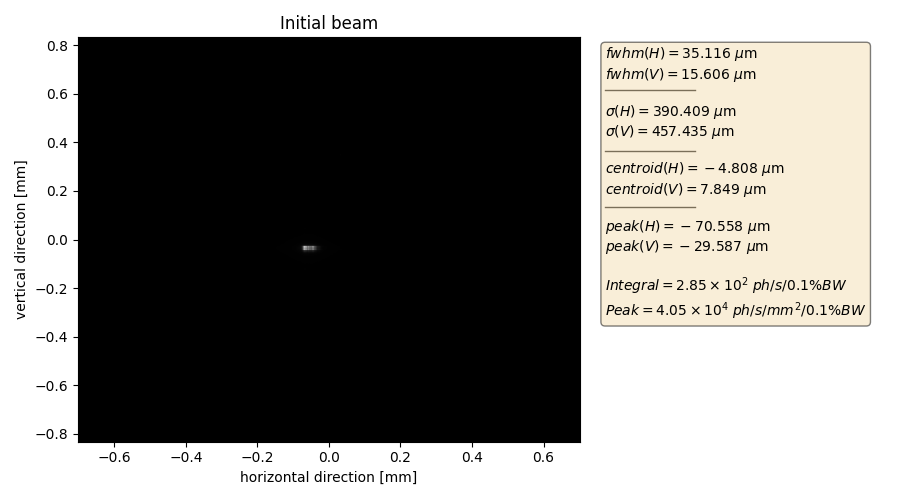

In [48]:
display_png(Image(filename = image_dirs[1] / 'Figure_1.png'))

In [49]:
!ls $data_base_dir

fwhm_lwsi_150_2022-11-18_images
fwhm_lwsi_150_2022-11-18_steps
fwhm_lwsi_autofocusing.ini
fwhm_lwsi_moo_150_2022-11-19_images
fwhm_lwsi_moo_150_2022-11-19_steps
fwhm_lwsi_moo_autofocusing.ini
fwhm_lwsi_moo_optimization_final_150_2022-11-19_14:37.gz
fwhm_lwsi_optimization_final_150_2022-11-18_23:21.gz


In [50]:
study = analysis.create_study_from_trials(data_base_dir / "fwhm_lwsi_moo_optimization_final_150_2022-11-19_14:37.gz")

[I 2023-05-11 23:47:21,729] A new study created in memory with name: no-name-03b08cec-e7df-466a-b949-f92b2570560f


Assuming minimization for all objectives.


In [51]:
n_steps = len(study.trials)

In [52]:
hists = analysis.load_histograms_from_files(n_steps,data_base_dir/ "fwhm_lwsi_moo_150_2022-11-19_steps", 'gz')

In [53]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [54]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[97, 109, 10, 134, 118, 97, 78]
128 [0.01209599292592494, 19.312229706577387]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3903716885098599, 'h_fwhm': 0.009754515979620848, 'h_centroid': -0.0012167564637538542, 'h_peak': -0.02503659101435851, 'v_sigma': 0.45755884783698614, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.004821532497745806, 'v_peak': 0.012679953106682285, 'integral_intensity': 285.0715015686262, 'peak_intensity': 65238.89, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.01209599292592494


Trial number 85
Trial values: peak_distance 1.930e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39050603581111043, 'h_fwhm': 0.016257526632701413, 'h_centroid': 0.003169374660824925, 'h_peak': 0.033490504863362615, 'v_sigma': 0.45748087296372497, 'v_fwhm': 0.010404064087534692, 'v_centroid': 0.004209281937263165, 'v_peak': 0.020483001172332867, 'integral_intensity': 284.94143633002574, 'peak_intensity': 55876.5, 'gaussian_fit': {}}}
Actual fwhm 0.01930159894284732


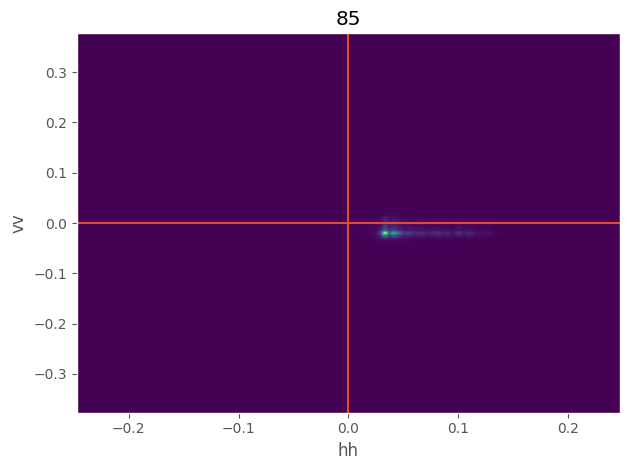

Trial number 90
Trial values: peak_distance 1.517e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39026100356571203, 'h_fwhm': 0.01300602130616113, 'h_centroid': -0.0013480649515152376, 'h_peak': -0.04389532190829092, 'v_sigma': 0.45738879696127066, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.005247591167499843, 'v_peak': 0.004226651035560713, 'integral_intensity': 285.254502222687, 'peak_intensity': 65134.523, 'gaussian_fit': {}}}
Actual fwhm 0.015167206378604381


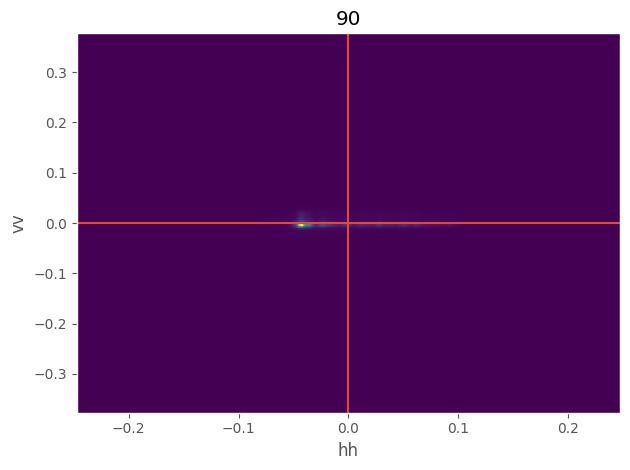

Trial number 121
Trial values: peak_distance 9.754e-03 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3904384741889806, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.0012415664023843476, 'h_peak': -0.03023899953682259, 'v_sigma': 0.45777747741340885, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.009394774112314652, 'v_peak': -0.049094177413051956, 'integral_intensity': 285.46020881415643, 'peak_intensity': 65449.562, 'gaussian_fit': {}}}
Actual fwhm 0.009754261862385233


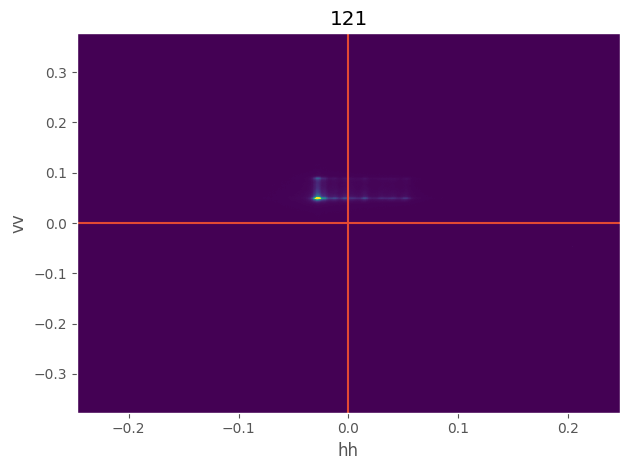

Trial number 128
Trial values: peak_distance 1.210e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3903716885098599, 'h_fwhm': 0.009754515979620848, 'h_centroid': -0.0012167564637538542, 'h_peak': -0.02503659101435851, 'v_sigma': 0.45755884783698614, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.004821532497745806, 'v_peak': 0.012679953106682285, 'integral_intensity': 285.0715015686262, 'peak_intensity': 65238.89, 'gaussian_fit': {}}}
Actual fwhm 0.01209599292592494


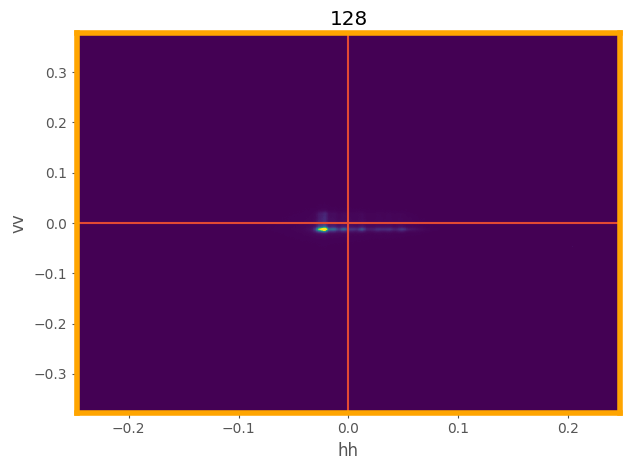

Trial number 140
Trial values: peak_distance 1.107e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39031894936550804, 'h_fwhm': 0.008453913849004735, 'h_centroid': -0.0029746045035284885, 'h_peak': -0.05234923575729503, 'v_sigma': 0.4574111408672301, 'v_fwhm': 0.007152794060180101, 'v_centroid': 0.005038186760355751, 'v_peak': 0.012679953106682285, 'integral_intensity': 285.28348679833016, 'peak_intensity': 65372.63, 'gaussian_fit': {}}}
Actual fwhm 0.011073893725051806


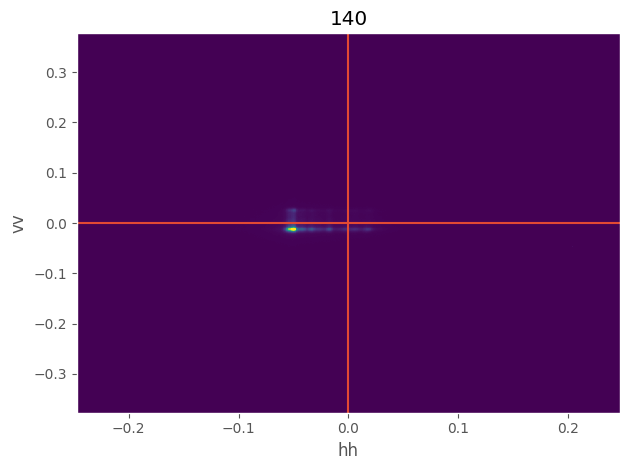

Trial number 146
Trial values: peak_distance 1.930e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.39009465259313036, 'h_fwhm': 0.010404817044928905, 'h_centroid': -0.0005689904729921647, 'h_peak': -0.010729967577582262, 'v_sigma': 0.4573931218887103, 'v_fwhm': 0.016256350136772957, 'v_centroid': 0.002995206108749815, 'v_peak': 0.03478858929269234, 'integral_intensity': 285.2896842472772, 'peak_intensity': 56168.75, 'gaussian_fit': {}}}
Actual fwhm 0.019301013898440703


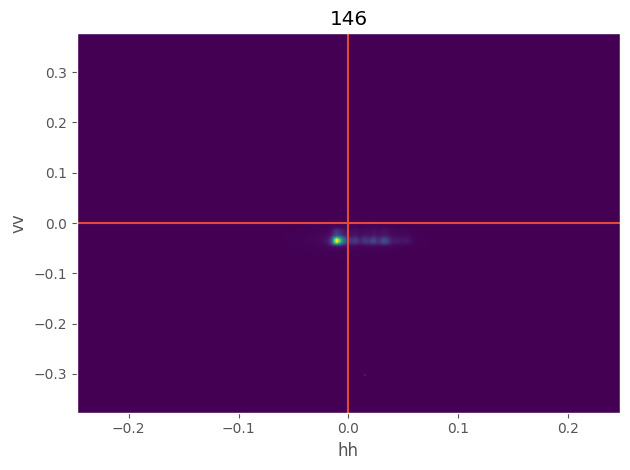

Trial number 148
Trial values: peak_distance 2.596e-02 fwhm 1.931e+01
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3900836612394969, 'h_fwhm': 0.024061139416398092, 'h_centroid': -0.0006433428234695893, 'h_peak': -0.012030569708198243, 'v_sigma': 0.45735405400174617, 'v_fwhm': 0.009753810082063774, 'v_centroid': 0.004212751904567935, 'v_peak': 0.019832747166862022, 'integral_intensity': 285.25834518229607, 'peak_intensity': 53100.23, 'gaussian_fit': {}}}
Actual fwhm 0.0259629590211192


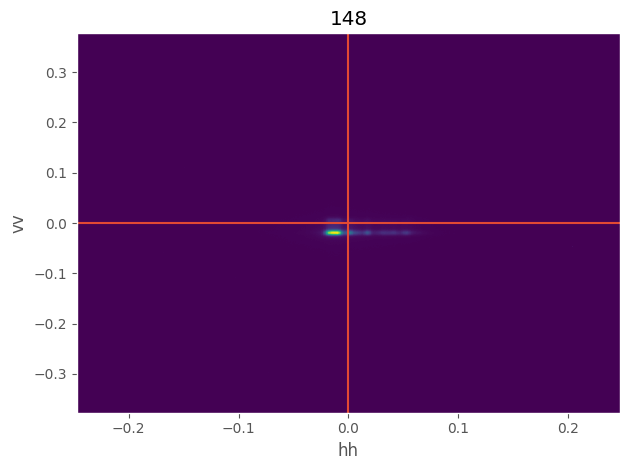

In [55]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.pcolormesh(hist.hh[700:-700], hist.vv[700:-700], hist.data_2D[700:-700,700:-700].T)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.axvline(0)
    plt.axhline(0)
    plt.xlabel('hh')
    plt.ylabel('vv')
    plt.title(t.number)
    plt.tight_layout()
    plt.show()

In [56]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['fwhm', 'lwsi'])

In [57]:
pareto_df

number      fwhm       lwsi    h_peak    v_peak    h_fwhm    v_fwhm  \
85       85  0.019302  19.311874  0.033491  0.020483  0.016258  0.010404   
90       90  0.015167  19.312215 -0.043895  0.004227  0.013006  0.007803   
121     121  0.009754  19.314469 -0.030239 -0.049094  0.007804  0.005852   
128     128  0.012096  19.312230 -0.025037  0.012680  0.009755  0.007153   
140     140  0.011074  19.312511 -0.052349  0.012680  0.008454  0.007153   
146     146  0.019301  19.311933 -0.010730  0.034789  0.010405  0.016256   
148     148  0.025963  19.311727 -0.012031  0.019833  0.024061  0.009754   

     peak_intensity  
85     55876.500000  
90     65134.523438  
121    65449.562500  
128    65238.890625  
140    65372.628906  
146    56168.750000  
148    53100.230469

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3075497487.py:3: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["fwhm", "lwsi"],


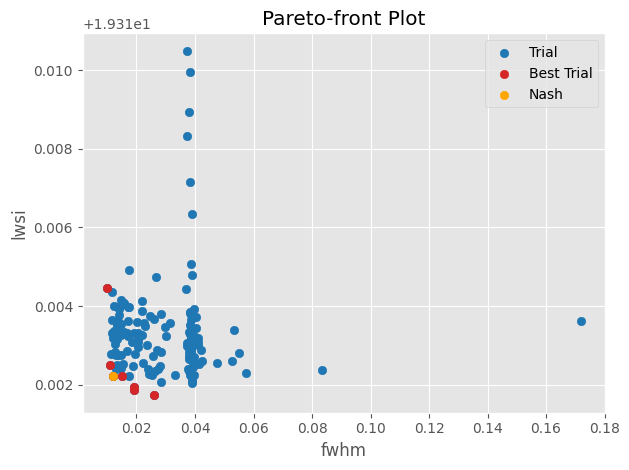

In [58]:
# Generating the pareto front for the multiobjective optimization

optuna.visualization.matplotlib.plot_pareto_front(study, target_names=["fwhm", "lwsi"], 
                                                  include_dominated_trials=True)
plt.scatter(*nash_trial.values, color='orange', label='Nash')
#plt.ylim(-11.10, -11)
#plt.xlim(0, 0.01)
plt.legend(loc='best')
plt.tight_layout()

# plt.savefig(...) to save the image
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3735537514.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="fwhm")


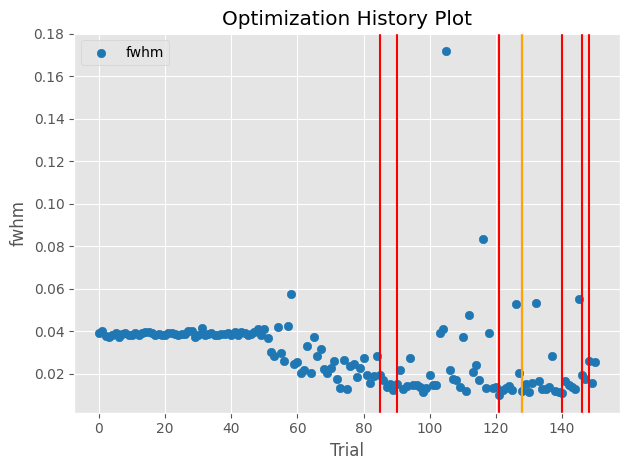

In [59]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/4145310622.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="lwsi")


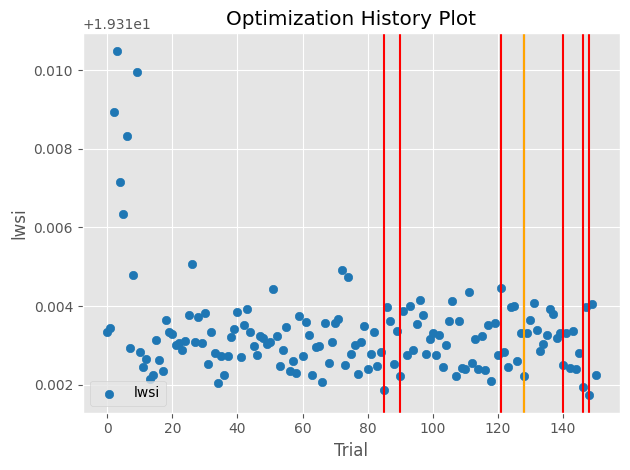

In [60]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[1], target_name="lwsi")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [61]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, 
                                                          target=lambda t: opt_common._get_peak_distance_from_dw(t.user_attrs["dw"]), 
                                                          target_name="peak_distance")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.ylim(0, 0.05)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3818570731.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study,


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/4190150875.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study,


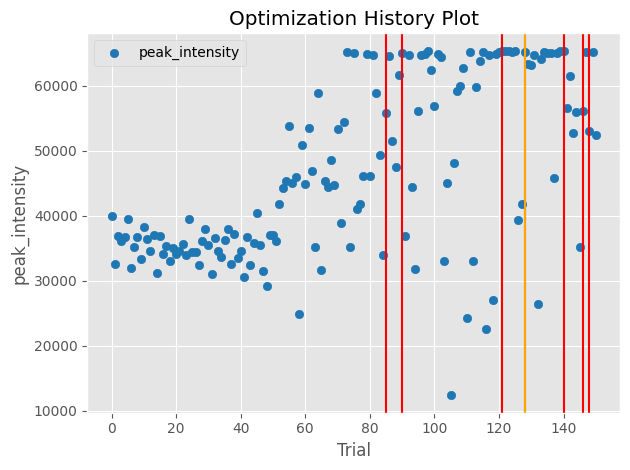

In [62]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, 
                                                          target=lambda t: opt_common._get_peak_intensity_from_dw(t.user_attrs["dw"]), 
                                                          target_name="peak_intensity")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='orange')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [63]:
new_hists = []
new_dws = []
for h in hists:
    h1, dw = analysis.recalculate_info(h, noise_threshold=1.5, crop=500)
    new_hists.append(h1)
    new_dws.append(dw)

In [64]:
wsums = [opt_common._get_weighted_sum_intensity_from_hist(h1, 2) for h1 in new_hists]

In [65]:
wsums = np.array(wsums)

In [66]:
# Plotting the optimization histories
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums[t.number]),
                                                          target_name="log_weighted_sum")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/436633895.py:2: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: np.log(wsums[t.number]),


In [67]:
# Plotting the optimization histories
sigmas = [opt_common._get_sigma_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: sigmas[t.number],
                                                          target_name="sigma")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/4268674650.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: sigmas[t.number],


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3370862287.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number],


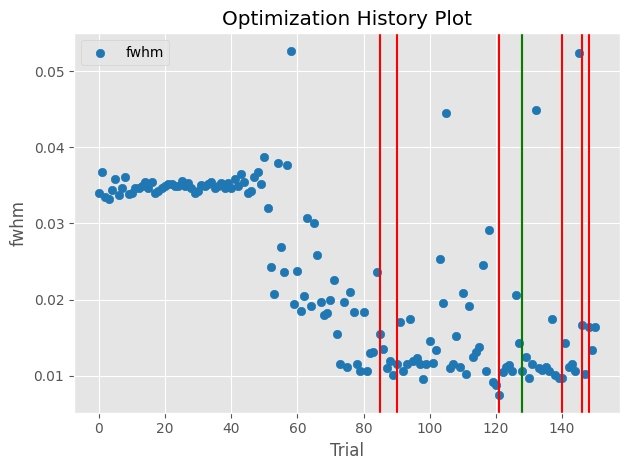

In [68]:
# Plotting the optimization histories
fwhms = [opt_common._get_fwhm_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: fwhms[t.number],
                                                          target_name="fwhm")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3952178995.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: kl_divs[t.number],


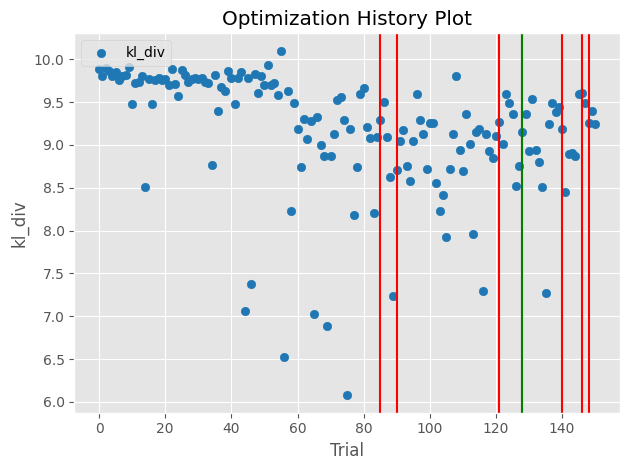

In [69]:
# Plotting the optimization histories
kl_divs  = [opt_common._get_kl_divergence_with_gaussian_from_hist(hist, ref_fwhm=(5e-3,5e-3)) for hist in new_hists]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: kl_divs[t.number],
                                                          target_name="kl_div")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [70]:
# Plotting the optimization histories
plocs = [opt_common._get_peak_distance_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: plocs[t.number],
                                                          target_name="peak_location")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/330897592.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: plocs[t.number],


In [71]:
# Plotting the optimization histories
pints = [opt_common._get_peak_intensity_from_dw(dw) for dw in new_dws]
optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: pints[t.number],
                                                          target_name="peak_intenisty")
for t in study.best_trials:
    plt.axvline(t.number, color='red')
plt.axvline(nash_trial.number, color='green')
plt.legend(loc="best")
plt.tight_layout()
plt.show()

/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_35460/3201353947.py:3: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: pints[t.number],


In [72]:
np.argmin(kl_divs)

75

In [73]:
tnum = 75
hdata = hists[tnum]
fig, ax = plt.subplots(1,1)

cax = plt.pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
plt.axvline(0)
plt.axhline(0)

val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[tnum]])
ax.set_title(f"{tnum:<6}, {val_strs}")
plt.colorbar(cax, ax=ax)
plt.show()

In [74]:
# FWHM, WSUM

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
                lambda t: np.log(wsums[t.number])]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

89 9


In [76]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4], constrained_layout=True)
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:3.2f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    #plt.colorbar(cax, ax=axs[i])
plt.show()

In [77]:
# FWHM, KL

test_val_fns = [lambda t: opt_common._get_fwhm_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

89 5


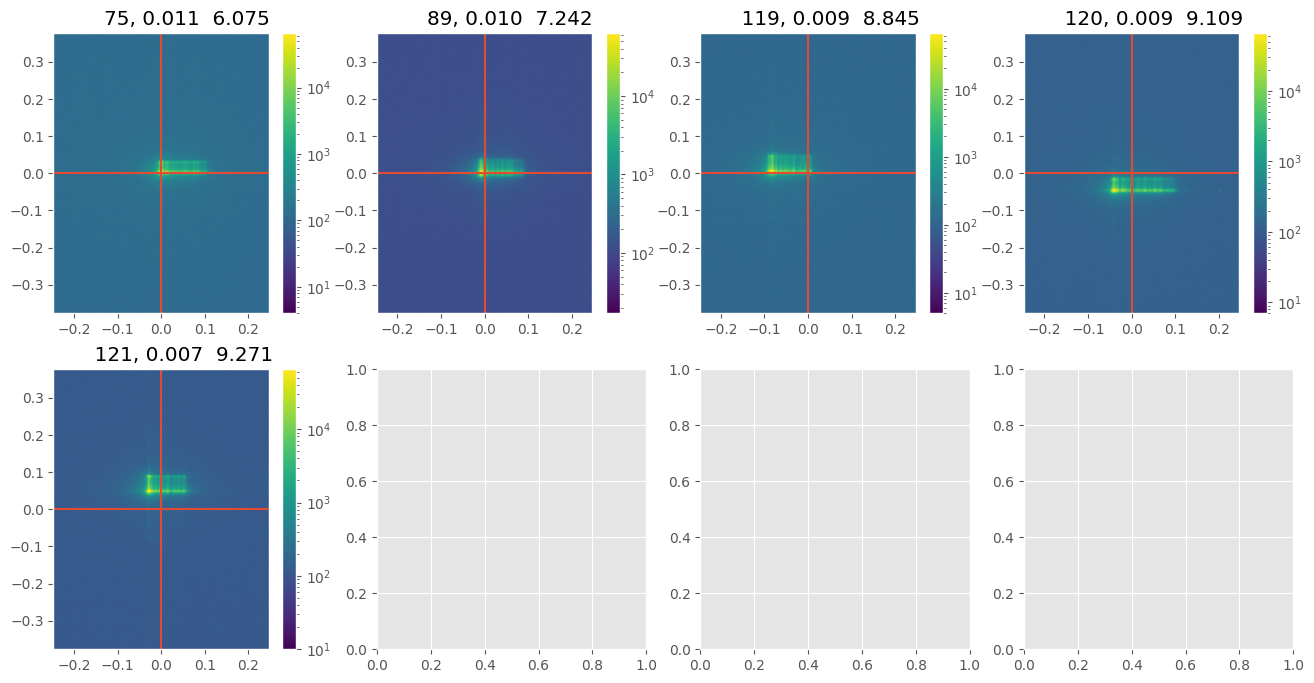

In [79]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [80]:
# centroid, KL

test_val_fns = [lambda t: opt_common._get_centroid_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

46 6


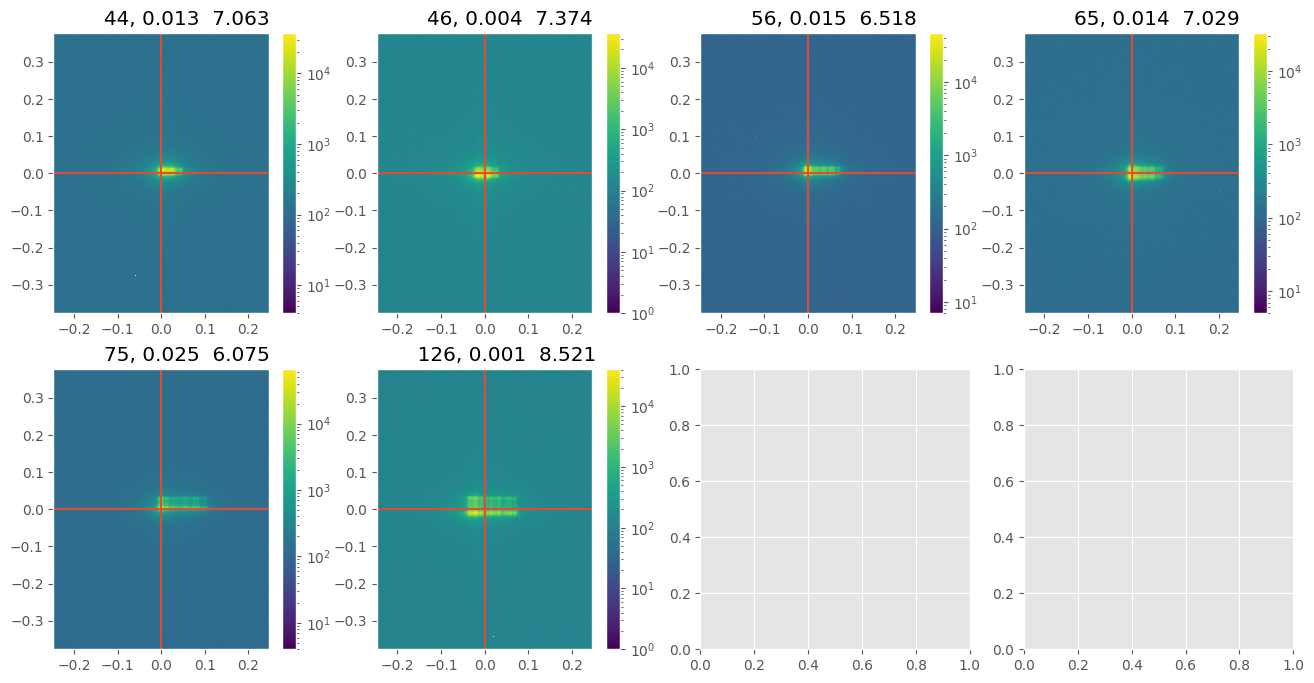

In [81]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [82]:
# peak_location, KL

test_val_fns = [lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

75 2


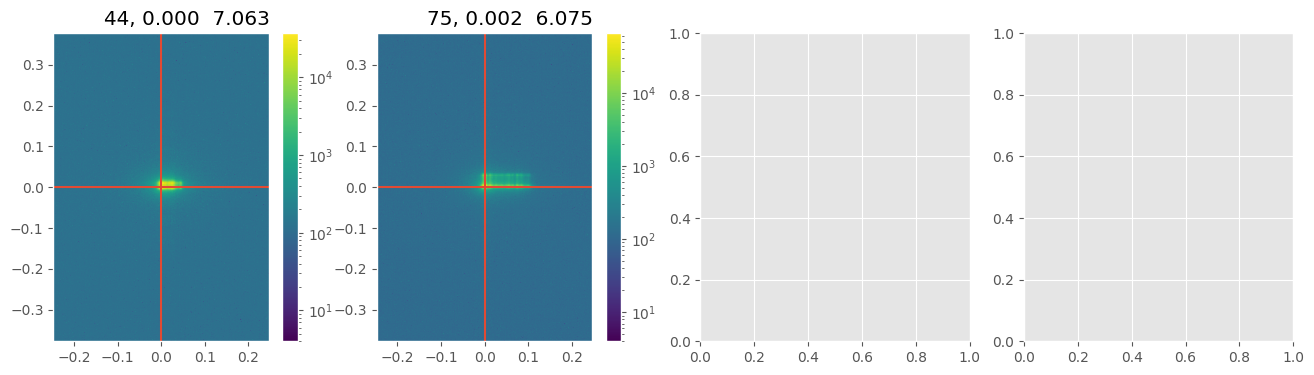

In [83]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [84]:
# peak_intensity, KL

test_val_fns = [lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])), 
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

75 6


In [85]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()

In [86]:
# peak_intensity, peak_location, KL

test_val_fns = [lambda t: -np.log(opt_common._get_peak_intensity_from_dw(new_dws[t.number])), lambda t: opt_common._get_peak_distance_from_dw(new_dws[t.number]),
                lambda t: kl_divs[t.number]]
test_values = []
for t in study.trials:
    test_values.append([vf(t) for vf in test_val_fns])


test_pareto = analysis.get_pareto_front_trials(study.trials, [1,1, 1], values_fns=test_val_fns)
domins = analysis.calculate_dominated_trials(study.trials, study.trials, [1,1,1], test_val_fns)
print(np.argmax(domins), len(test_pareto))

75 9


In [87]:
n_rows = np.ceil(len(test_pareto) / 4).astype('int')

fig, axs = plt.subplots(n_rows, 4, figsize=[16, n_rows * 4])
axs = axs.ravel()

for i, t in enumerate(test_pareto):
    

    hdata = hists[t.number]
    
    cax = axs[i].pcolormesh(hdata.hh[700:-700], hdata.vv[700:-700][:,None], hdata.data_2D[700:-700,700:-700].T, norm=mpl.colors.LogNorm())
    axs[i].axvline(0)
    axs[i].axhline(0)
    
    val_strs = "  ".join([f"{tval:4.3f}" for tval in test_values[t.number]])
    axs[i].set_title(f"{t.number:>10}, {val_strs}")
    plt.colorbar(cax, ax=axs[i])
plt.show()